# Programming for Data Science and Artificial Intelligence

## 17. Recurrent Neural Networks from Scratch

- [WEIDMAN] Ch6
- [CHARU] Ch7

In [39]:
from numpy import ndarray
from typing import Dict, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from IPython import display
from copy import deepcopy

Recurrent neural networks are designed to handle data that appears in sequences: instead of size **(batch_size, features)**, now we add additional dimension which is **time steps**

<img src = "figures/rnn.png" width=300>

For example, one observation could have the features from time t = 1 with the value of the target from time t = 2, the next observation could have the features from time t = 2 with the value of the target from time t = 3, and so on. If we wanted to use data from multiple time steps to make each prediction rather than data from just one time step, we could use the features from t = 1 and t = 2 to predict the target at t = 3, the features from t = 2 and t = 3 to predict the target at t = 4, and so on.

However, **treating each time step as independent ignores the fact that the data is ordered sequentially**. How would we ideally want to use the sequential nature of the data to make better predictions? The solution would look something like this:

1. Use features from time step t = 1 to make predictions for the corresponding target at t = 1.

2. Use features from time step t = 2 as well as the information from t = 1, including the value of the target at t = 1, to make predictions for t = 2.

3. Use features from time step t = 3 as well as the accumulated information from t = 1 and t = 2 to make predictions at t = 3.

4. And so on, at each step using the information from all prior time steps to make a prediction.

To do this, it seems that we'd want to pass our data through the neural network one sequence element at a time, with the data from the first time step being passed through first, then the data from the next time step, and so on. In addition, we’ll want our neural network to **accumulate information** about what it has seen before as the new sequence elements are passed through. 

In a more concrete fashion, consider the following steps and figure:

1. In the first time step, t = 1, we would pass through the observation from the first time step (along with randomly initialized representations, perhaps). We would output a prediction for t = 1, along with representations at each layer.

2. In the next time step, we would pass through the observation from the second time step, t = 2, **along with the representations computed during the first time step** (which, again, are just the outputs of the neural network’s layers), and combine these somehow (it is in this combining step that the variants of RNNs we'll learn about differ). We would use these two pieces of information to output a prediction for t = 2 as well as the updated representations at each layer, which are now a function of the inputs passed in at both t = 1 and t = 2.

3. In the third time step, we would pass through the observation from t = 3, as well as the representations that now incorporate the information from t = 1 and t = 2, and use this information to make predictions for t = 3, as well as additional updated representations at each layer, which now incorporate information from time steps 1–3.

This process is depicted in this figure:

<img src = "figures/rnn2.png" width=450>

We see that each layer has a representation that is **persistent** getting updated over time as new observations are passed through.

### The First Class for RNNs: RNNLayer

RNNs will deal with data in which each observation is two-dimensional, with dimensions `(sequence_length, num_features)` - order is not important; and since it is always more efficient computationally to pass data forward in batches, `RNNLayer` will have to take in three-dimensional ndarrays, of size `(batch_size, sequence_length, num_features)`. 

However, we want to feed our data through our `RNNLayers` one sequence element at a time as shown in the previous picture; how can we do this if our input, data, is `(batch_size, sequence_length, num_features)`? Here’s how:

1. Select a two-dimensional array from the second axis, starting with `data[:, 0, :]`. This ndarray will have shape `(batch_size, num_features)`.

2. Initialize a **hidden state** for the `RNNLayer` that will continually get updated with each sequence element passed in, this time of shape `(batch_size, hidden_size)`. This ndarray will represent the layer’s **accumulated information** about the data that has been passed in during the prior time steps.

3. Pass these two ndarrays forward through the first time step in this layer. We'll end up designing `RNNLayer` to output `ndarrays` of different dimensionality than the inputs, just like regular Dense layers can, so the output will be of shape `(batch_size, num_outputs)`. In addition, update the neural network’s representation for **each observation**: at **each time step**, our `RNNLayer` should also output an ndarray of shape `(batch_size, hidden_size)`.

4. Select the next two-dimensional array from data: `data[:, 1, :]`.

5. Pass this data, as well as the values of the `RNN`’s representations outputted at the first time step, into the second time step at this layer to get another output of shape `(batch_size, num_outputs)`, as well as updated representations of shape `(batch_size, hidden_size)`.

6. Continue until all sequence_length time steps have been passed through the layer. Then concatenate all the results together to get an output from that layer of shape `(batch_size, sequence_length, num_outputs)`.

This gives us an idea of how our `RNNLayers` should work—and we'll solidify this understanding when we code it up—but it also hints that we'll need another class to handle receiving the data and updating the layer's hidden state at each time step. For this we'll use the `RNNNode`, the next class we’ll cover.

### The Second Class for RNNs: RNNNode

Based on the description from the prior section, an RNNNode should have a forward method with the following inputs and outputs:

Two ndarrays as inputs:

- One for the data inputs to the network, of shape `[batch_size, num_features]`
- One for the representations of the observations at that time step, of shape `[batch_size, hidden_size]`

Two ndarrays as outputs:

- One for the outputs of the network at that time step, or shape `[batch_size, num_outputs]`
- One for the updated representations of the observations at that time step, of shape: `[batch_size, hidden_size]`

Next, we’ll show how the two classes, RNNNode and RNNLayer, fit together.

### Putting These Two Classes Together

The RNNLayer class will wrap around a list of `RNNNodes` and will (at least) contain a `forward` method that has the following inputs and outputs:

- Input: a batch of sequences of observations of shape `[batch_size, sequence_length, num_features]`

- Output: the neural network output of those sequences of shape `[batch_size, sequence_length, num_outputs]`

The figure below shows the order that data would move forward through an `RNN` with two `RNNLayers` with five `RNNNodes` each. At each time step, inputs initially of dimension `feature_size` are passed successively forward through the first `RNNNode` in each `RNNLayer`, with the network ultimately outputting a prediction at that time step of dimension output_size. In addition, each RNNNode passes a **hidden state** forward to the next `RNNNode` within each layer. Once data from each of the five time steps has been passed forward through all the layers, we will have a final set of predictions of shape `(5, output_size)`, where `output_size` should be the same dimension as the targets. These predictions would then be compared to the target, and the loss gradient would be computed, kicking off the backward pass.

<img src = "figures/rnn3.png" width=600>

Alternatively, data could flow through the RNN in the order shown below. Whatever the order, the following must occur:

- Each layer needs to process its data at a given time step before the next layer—for example, in above, 2 can’t happen before 1, and 4 can’t happen before 3.

- Similarly, each layer has to process all of its time steps in order—in figure above, for example, 4 can’t happen before 2, and 3 can’t happen before 1.

- The last layer has to output dimension feature_size for each observation.

<img src = "figures/rnn4.png" width=600>

### The Backward Pass

Backpropagation through recurrent neural networks is often described as a separate algorithm called **backpropagation through time.** While this does indeed describe what happens during backpropagation, it makes things sound a lot more complicated than they are. Keeping in mind the explanation of how data flows forward through an RNN, we can describe what happens on the backward pass this way: we pass data backward through the `RNN` by passing gradients backward through the network in reverse of the order that we passed inputs forward on the forward pass—which, indeed, is the same thing we do in regular feed-forward networks.

Looking at the diagrams in figures above on the forward pass:

1. We start with a batch of observations, each of shape `(feature_size, sequence_length)`.

2. These inputs are broken up into the individual `sequence_length` elements and passed into the network one at a time.

3. Each element gets passed through all the layers, ultimately getting transformed into an output of size `output_size`.

4. At the same time, the layer passes the hidden state forward into the layer’s computation at the next time step.

5. This continues for all `sequence_length` time steps, resulting in a total output of size `(output_size, sequence_length)`.

Backpropagation simply works the same way, but in reverse:

1. We start with a gradient of shape `[output_size, sequence_length]`, representing how much each element of the output (also of size `[output_size, sequence_length]`) ultimately impacts the loss computed for that batch of observations.

2. These gradients are broken up into the individual `sequence_length` elements and passed backward through the layers in reverse order.

3. The gradient for an individual element is passed backward through all the layers.

4. At the same, the layers pass the gradient of the loss with respect to the hidden state at that time step backward into the layers’ computations at the prior time steps.

5. This continues for all `sequence_length` time steps, until the gradients have been passed backward to every layer in the network, thus allowing us to compute the gradient of the loss with respect to each of the weights, just as we do in the case of regular feed-forward networks.

This parallelism between the backward and forward pass is highlighted in the figure below, which shows how data flows through an RNN during the backward pass. You’ll notice, of course, that it is the very similar as figures above but with reversed arrows.

<img src = "figures/rnn5.png" width=600>

This highlights that, at a high level, the forward and backward passes for an RNNLayer are very similar to those of a layer in a normal neural network: they both receive `ndarrays` of a certain shape as input, output `ndarrays` of another shape, and on the backward pass receive an **output gradient of the same shape as their output and produce an input gradient of the same shape as their input**. There is a key difference in the way the weight gradients are handled in `RNNLayers` versus other layers, however, so we’ll briefly cover that before we shift to coding this all up.

### Accumulating gradients for the weights in an RNN

In recurrent neural networks, just as in regular neural networks, each layer will have one set of weights. That means that the same set of weights will affect the layer's output at all sequence_length time steps; during backpropagation, therefore, the same set of weights will receive `sequence_length` different gradients. For example, in the circle labeled *1* in the backpropagation shown in figure above, the second layer will receive a gradient for the last time step, while in the circle labeled *3*, the layer will receive a gradient for the second-to-last time step; both of these will be driven by the same set of weights. Thus, during backpropagation, we'll have to accumulate gradients for the weights over a series of time steps, which means that however we choose to store the weights, we'll have to update their gradients using something like the following:

`weight_grad += grad_from_time_step`

This is different from the `Dense` and `Conv2D` layers, in which we just stored the parameters in a param_grad argument.

We’ve laid out how `RNNs` work and the classes we want to build to implement them; now let’s start figuring out the details.

## RNNs: The Code

Firstly, let's code up all the activation functions so our layers can make use of that.  Also some helper function.  To make our learning a bit smooth, we shall first cover things that remain unchanged, comparing to the our NeuralNetwork we learn - including Loss

### Activations

In [32]:
def sigmoid(x: ndarray):
    return 1 / (1 + np.exp(-x))


def dsigmoid(x: ndarray):
    return sigmoid(x) * (1 - sigmoid(x))


def tanh(x: ndarray):
    return np.tanh(x)


def dtanh(x: ndarray):
    return 1 - np.tanh(x) * np.tanh(x)


def softmax(x, axis=None):
        #keepdims so that this number can be broadcasted and divided
        return np.exp(x) / np.sum(np.exp(x), axis=axis, keepdims=True)

def batch_softmax(input_array: ndarray):
    out = []
    for row in input_array:
        out.append(softmax(row, axis=1))
    return np.stack(out)

### Helpers

In [28]:
def assert_same_shape(a: np.ndarray,
                      b: np.ndarray):
    assert a.shape == b.shape
    return None

### Loss

The Loss for RNNs is the same as before: an `ndarray` output is produced by the last Layer and compared with `y_batch`, a single value is computed, and a gradient of this value with respect to the input to the Loss is returned with the same shape as output. We’ll have to modify the softmax function to work appropriately with ndarrays of shape `[batch_size, sequence_length, feature_size]`, but we can handle that.

In [20]:
class Loss(object):

    def __init__(self):
        pass

    def forward(self,
                prediction: ndarray,
                target: ndarray) -> float:

        assert_same_shape(prediction, target)

        self.prediction = prediction
        self.target = target

        self.output = self._output()

        return self.output
    
    def backward(self) -> ndarray:

        self.input_grad = self._input_grad()

        assert_same_shape(self.prediction, self.input_grad)

        return self.input_grad

    def _output(self) -> float:
        raise NotImplementedError()

    def _input_grad(self) -> ndarray:
        raise NotImplementedError()

        
class SoftmaxCrossEntropy(Loss):
    def __init__(self, eps: float=1e-9) -> None:
        super().__init__()
        self.eps = eps
        self.single_class = False

    def _output(self) -> float:

        #-----revised here----to handle sequences----
        out = []
        for row in self.prediction:
            out.append(softmax(row, axis=1))
        softmax_preds = np.stack(out)
        #--------------------------------------------

        # clipping the softmax output to prevent numeric instability
        self.softmax_preds = np.clip(softmax_preds, self.eps, 1 - self.eps)

        # actual loss computation
        softmax_cross_entropy_loss = -1.0 * self.target * np.log(self.softmax_preds) - \
            (1.0 - self.target) * np.log(1 - self.softmax_preds)

        return np.sum(softmax_cross_entropy_loss)

    def _input_grad(self) -> np.ndarray:

        return self.softmax_preds - self.target

### RNN Layer

The Layers themselves are where things get interesting.

Previously, we gave `Layers` a set of `Operations` that passed data forward and sent gradients backward. `RNNLayers` will be completely different; they now must maintain a *hidden state* that continually gets updated as new data gets fed in and gets *combined* with the data somehow at each time step. How exactly should this work? 

The forward pass figures suggest that each `RNNLayer` should have a `List` of `RNNNodes` as an attribute, and then each sequence element from the layer’s input should get passed through each `RNNNode`, one element at a time. Each `RNNNode` will take in this sequence element, as well as the *hidden state* for that layer, and produce an output for the layer at that time step as well as updating the layer’s hidden state.

To clarify all this, let's dive in and start coding it up: we'll cover, in order, how an `RNNLayer` should be initialized, how it should send data forward during the forward pass, and how it should send data backward during the backward pass.

**Initialization**

Each `RNNLayer` will start with:

- An int hidden_size
- An int output_size
- An ndarray start_H of shape (1, hidden_size), representing the layer’s hidden state

In addition, just like in regular neural networks, we'll set `self.first = True` when we initialize the layer; the first time we pass data into the forward method we’ll pass the ndarray we receive into an `_init_params` method, initialize the parameters, and set `self.first = False`.

**Forward**

The bulk of the forward method will consist of taking in an `ndarray x_seq_in` of shape `(batch_size, sequence_length, feature_size)` and feeding it through the layer’s `RNNNodes` in sequence. In the following code, `self.nodes` are the `RNNNodes` for the layer, and `H_in` is the hidden state for the layer:

<code>   sequence_length = x_seq_in.shape[1]
    x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))
    for t in range(sequence_length):
        x_in = x_seq_in[:, t, :]
        y_out, H_in = self.nodes[t].forward(x_in, H_in, self.params)
        x_seq_out[:, t, :] = y_out
</code>

One note on the hidden state `H_in`: the hidden state for an `RNNLayer` is typically represented in a vector, but the operations in each `RNNNode` require the hidden state to be an `ndarray` of size `(batch_size, hidden_size)`. So, at the beginning of each forward pass, we simply *repeat* the hidden state:

<code>batch_size = x_seq_in.shape[0]
H_in = np.copy(self.start_H)
H_in = np.repeat(H_in, batch_size, axis=0)
</code>
    
After the forward pass, we take the average value across the observations making up the batch to get the updated hidden state for that layer:

`self.start_H = H_in.mean(axis=0, keepdims=True)`

As you can see,  an RNNNode will have to have a forward method that takes in two arrays of shapes:

- (batch_size, feature_size)
- (batch_size, hidden_size)

and returns two arrays of shapes:

- (batch_size, output_size)
- (batch_size, hidden_size)

**Backward**

Since the forward method outputted `x_seq_out`, the backward method will receive a gradient of the same shape as `x_seq_out` called `x_seq_out_grad`. Moving in the opposite direction from the `forward` method, we feed this gradient backward through the `RNNNodes`, ultimately returning `x_seq_in_grad` of shape `(batch_size, sequence_length, self.feature_size)` as the gradient for the entire layer:

<code>h_in_grad = np.zeros((batch_size, self.hidden_size))
sequence_length = x_seq_out_grad.shape[1]
x_seq_in_grad = np.zeros((batch_size, sequence_length, self.feature_size))
for t in reversed(range(sequence_length)):
    x_out_grad = x_seq_out_grad[:, t, :]
    grad_out, h_in_grad = self.nodes[t].backward(x_out_grad, h_in_grad, self.params)
    x_seq_in_grad[:, t, :] = grad_out
</code>

From this, we see that `RNNNodes` should have a backward method that, following the pattern, is the opposite of the forward method, taking in two arrays of shapes:

- (batch_size, output_size)
- (batch_size, hidden_size)

and returning two arrays of shapes:

- (batch_size, feature_size)
- (batch_size, hidden_size)

And that’s the working of an `RNNLayer`. Now it seems like the only thing left is to describe the core of recurrent neural networks: the `RNNNodes` where the actual computations happen. Before we do, let’s clarify the role of `RNNNodes` and their variants within `RNNs` as a whole.

In [17]:
class RNNLayer(object):

    def __init__(self,
                 hidden_size: int,
                 output_size: int,
                 weight_scale: float = None):
        '''
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param learning_rate: float - the learning rate
        '''
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, hidden_size))
        self.first = True


    def _init_params(self,
                     input_: ndarray):
        
        self.vocab_size = input_.shape[2]
        
        if not self.weight_scale:
            self.weight_scale = 2 / (self.vocab_size + self.output_size)
        
        self.params = {}
        self.params['W_f'] = {}
        self.params['B_f'] = {}
        self.params['W_v'] = {}
        self.params['B_v'] = {}
        
        self.params['W_f']['value'] = np.random.normal(loc = 0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_f']['value'] = np.random.normal(loc = 0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size, self.output_size))
        self.params['B_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.output_size))    
        
        self.params['W_f']['deriv'] = np.zeros_like(self.params['W_f']['value'])
        self.params['B_f']['deriv'] = np.zeros_like(self.params['B_f']['value'])
        self.params['W_v']['deriv'] = np.zeros_like(self.params['W_v']['value'])
        self.params['B_v']['deriv'] = np.zeros_like(self.params['B_v']['value'])
        
        self.cells = [RNNNode() for x in range(input_.shape[1])]

    
    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])
        

    def forward(self, x_seq_in: ndarray):
        '''
        param x_seq_in: numpy array of shape (batch_size, sequence_length, vocab_size)
        return x_seq_out: numpy array of shape (batch_size, sequence_length, output_size)
        '''
        if self.first:
            self._init_params(x_seq_in)
            self.first=False
        
        batch_size = x_seq_in.shape[0]
        
        H_in = np.copy(self.start_H)
        
        H_in = np.repeat(H_in, batch_size, axis=0)

        sequence_length = x_seq_in.shape[1]
        
        x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))
        
        for t in range(sequence_length):

            x_in = x_seq_in[:, t, :]
            
            y_out, H_in = self.cells[t].forward(x_in, H_in, self.params)
      
            x_seq_out[:, t, :] = y_out
    
        self.start_H = H_in.mean(axis=0, keepdims=True)
        
        return x_seq_out


    def backward(self, x_seq_out_grad: ndarray):
        '''
        param loss_grad: numpy array of shape (batch_size, sequence_length, vocab_size)
        return loss_grad_out: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''
        batch_size = x_seq_out_grad.shape[0]
        
        h_in_grad = np.zeros((batch_size, self.hidden_size))
        
        sequence_length = x_seq_out_grad.shape[1]
        
        x_seq_in_grad = np.zeros((batch_size, sequence_length, self.vocab_size))
        
        for t in reversed(range(sequence_length)):
            
            x_out_grad = x_seq_out_grad[:, t, :]

            grad_out, h_in_grad = \
                self.cells[t].backward(x_out_grad, h_in_grad, self.params)
        
            x_seq_in_grad[:, t, :] = grad_out
        
        return x_seq_in_grad

### RNNModel

An RNN still passes data forward through a series of layers, which send outputs forward on the forward pass and gradients backward on the backward pass. Thus, for example, whatever the equivalent of our `NeuralNetwork` class ends up being will still have a list of `RNNLayers` as a layers attribute.

In [14]:
class RNNModel(object):
    '''
    The Model class that takes in inputs and targets and actually trains the network and calculates the loss.
    '''
    def __init__(self, 
                 layers: List[RNNLayer],
                 sequence_length: int, 
                 vocab_size: int, 
                 loss: Loss):
        '''
        param num_layers: int - the number of layers in the network
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the each layer of the network.
        '''
        self.layers = layers
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.loss = loss
        for layer in self.layers:
            setattr(layer, 'sequence_length', sequence_length)

        
    def forward(self, 
                x_batch: ndarray):
        '''
        param inputs: list of integers - a list of indices of characters being passed in as the 
        input sequence of the network.
        returns x_batch_in: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''       
        
        for layer in self.layers:

            x_batch = layer.forward(x_batch)
                
        return x_batch
        
    def backward(self, 
                 loss_grad: ndarray):
        '''
        param loss_grad: numpy array with shape (batch_size, sequence_length, vocab_size)
        returns loss: float, representing mean squared error loss
        '''

        for layer in reversed(self.layers):

            loss_grad = layer.backward(loss_grad)
            
        return loss_grad
                
    def single_step(self, 
                    x_batch: ndarray, 
                    y_batch: ndarray):
        '''
        The step that does it all:
        1. Forward pass & softmax
        2. Compute loss and loss gradient
        3. Backward pass
        4. Update parameters
        param inputs: array of length sequence_length that represents the character indices of the inputs to
        the network
        param targets: array of length sequence_length that represents the character indices of the targets
        of the network 
        return loss
        '''  
        
        x_batch_out = self.forward(x_batch)
        
        loss = self.loss.forward(x_batch_out, y_batch)
        
        loss_grad = self.loss.backward()
        
        for layer in self.layers:
            layer._clear_gradients()
        
        self.backward(loss_grad)
        return loss

### Trainer

The `Trainer` is mostly the same: we cycle through our training data, selecting batches of input data and batches of output data, and continually feed them through our model, producing loss values that tell us whether our model is learning and updating the weights after each batch has been fed through.

In [21]:
class RNNTrainer:
    '''
    Takes in a text file and a model, and starts generating characters.
    '''
    def __init__(self, 
                 text_file: str, 
                 model: RNNModel,
                 optim: RNNOptimizer,
                 batch_size: int = 32):
        self.data = open(text_file, 'r').read()
        self.model = model
        self.chars = list(set(self.data))
        self.vocab_size = len(self.chars)
        self.char_to_idx = {ch:i for i,ch in enumerate(self.chars)}
        self.idx_to_char = {i:ch for i,ch in enumerate(self.chars)}
        self.sequence_length = self.model.sequence_length
        self.batch_size = batch_size
        self.optim = optim
        setattr(self.optim, 'model', self.model)
    

    def _generate_inputs_targets(self, 
                                 start_pos: int):
        
        inputs_indices = np.zeros((self.batch_size, self.sequence_length), dtype=int)
        targets_indices = np.zeros((self.batch_size, self.sequence_length), dtype=int)
        
        for i in range(self.batch_size):
            
            inputs_indices[i, :] = np.array([self.char_to_idx[ch] 
                            for ch in self.data[start_pos + i: start_pos + self.sequence_length  + i]])
            targets_indices[i, :] = np.array([self.char_to_idx[ch] 
                         for ch in self.data[start_pos + 1 + i: start_pos + self.sequence_length + 1 + i]])

        return inputs_indices, targets_indices


    def _generate_one_hot_array(self, 
                                indices: ndarray):
        '''
        param indices: numpy array of shape (batch_size, sequence_length)
        return batch - numpy array of shape (batch_size, sequence_length, vocab_size)
        ''' 
        batch = []
        for seq in indices:
            
            one_hot_sequence = np.zeros((self.sequence_length, self.vocab_size))
            
            for i in range(self.sequence_length):
                one_hot_sequence[i, seq[i]] = 1.0

            batch.append(one_hot_sequence) 

        return np.stack(batch)


    def sample_output(self, 
                      input_char: int, 
                      sample_length: int):
        '''
        Generates a sample output using the current trained model, one character at a time.
        param input_char: int - index of the character to use to start generating a sequence
        param sample_length: int - the length of the sample output to generate
        return txt: string - a string of length sample_length representing the sample output
        '''
        indices = []
        
        sample_model = deepcopy(self.model)
        
        for i in range(sample_length):
            input_char_batch = np.zeros((1, 1, self.vocab_size))
            
            input_char_batch[0, 0, input_char] = 1.0
            
            x_batch_out = sample_model.forward(input_char_batch)
            
            x_softmax = batch_softmax(x_batch_out)
            
            input_char = np.random.choice(range(self.vocab_size), p=x_softmax.ravel())
            
            indices.append(input_char)
            
        txt = ''.join(self.idx_to_char[idx] for idx in indices)
        return txt

    def train(self, 
              num_iterations: int, 
              sample_every: int=100):
        '''
        Trains the "character generator" for a number of iterations. 
        Each "iteration" feeds a batch size of 1 through the neural network.
        Continues until num_iterations is reached. Displays sample text generated using the latest version.
        '''
        plot_iter = np.zeros((0))
        plot_loss = np.zeros((0))
        
        num_iter = 0
        start_pos = 0
        
        moving_average = deque(maxlen=100)
        while num_iter < num_iterations:
            
            if start_pos + self.sequence_length + self.batch_size + 1 > len(self.data):
                start_pos = 0
            
            ## Update the model
            inputs_indices, targets_indices = self._generate_inputs_targets(start_pos)

            inputs_batch, targets_batch = \
                self._generate_one_hot_array(inputs_indices), self._generate_one_hot_array(targets_indices)
            
            loss = self.model.single_step(inputs_batch, targets_batch)
            self.optim.step()
            
            moving_average.append(loss)
            ma_loss = np.mean(moving_average)
            
            start_pos += self.batch_size
            
            plot_iter = np.append(plot_iter, [num_iter])
            plot_loss = np.append(plot_loss, [ma_loss])
            
            if num_iter % 100 == 0:
                plt.plot(plot_iter, plot_loss)
                display.clear_output(wait=True)
                plt.show()
                
                sample_text = self.sample_output(self.char_to_idx[self.data[start_pos]], 
                                                 200)
                print(sample_text)

            num_iter += 1

### Optimizer

Our `Optimizer` remains the same as well. As we'll see, we'll have to update how we extract the `params` and `param_grads` at each time step, but the *update rules* (which we captured in the _update_rule function in our class) remain the same.

In [22]:
class RNNOptimizer(object):
    def __init__(self,
                 lr: float = 0.01,
                 gradient_clipping: bool = True) -> None:
        self.lr = lr
        self.gradient_clipping = gradient_clipping
        self.first = True

    def step(self) -> None:

        for layer in self.model.layers:
            for key in layer.params.keys():

                if self.gradient_clipping:
                    np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['deriv'])

                self._update_rule(param=layer.params[key]['value'],
                                  grad=layer.params[key]['deriv'])

    def _update_rule(self, **kwargs) -> None:
        raise NotImplementedError()
        
        
class SGD(RNNOptimizer):
    def __init__(self,
                 lr: float = 0.01,
                 gradient_clipping: bool = True) -> None:
        super().__init__(lr, gradient_clipping)

    def _update_rule(self, **kwargs) -> None:

        update = self.lr*kwargs['grad']
        kwargs['param'] -= update
        
class AdaGrad(RNNOptimizer):
    def __init__(self,
                 lr: float = 0.01,
                gradient_clipping: bool = True) -> None:
        super().__init__(lr, gradient_clipping)
        self.eps = 1e-7

    def step(self) -> None:
        if self.first:
            self.sum_squares = {}
            for i, layer in enumerate(self.model.layers):
                self.sum_squares[i] = {}
                for key in layer.params.keys():
                    self.sum_squares[i][key] = np.zeros_like(layer.params[key]['value'])
            
            self.first = False

        for i, layer in enumerate(self.model.layers):
            for key in layer.params.keys():
                
                if self.gradient_clipping:
                    np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['deriv'])
                
                self._update_rule(param=layer.params[key]['value'],
                                  grad=layer.params[key]['deriv'],
                                  sum_square=self.sum_squares[i][key])

    def _update_rule(self, **kwargs) -> None:

            # Update running sum of squares
            kwargs['sum_square'] += (self.eps +
                                     np.power(kwargs['grad'], 2))

            # Scale learning rate by running sum of squareds=5
            lr = np.divide(self.lr, np.sqrt(kwargs['sum_square']))

            # Use this to update parameters
            kwargs['param'] -= lr * kwargs['grad']

### RNNNodes

In most treatments of RNNs, the first thing discussed is the workings of what we are here calling `RNNNodes`. However, we cover these last because this is the most important concepts to understand about RNNs: **the way the data is structured and the way it and the hidden states are routed between layers and through time. As it turns out, there are multiple ways we can implement RNNNodes, the actual processing of the data from a given time step, and updating of the layer’s hidden state**

One way produces what is usually thought of as a *regular* recurrent neural network, which we'll refer to here by another common term: a **vanilla RNN.** However, there are other, more complicated ways that produce different variants of RNNs; one of these, for example, is a variant with RNNNodes called **GRUs**, which stands for**Gated Recurrent Units.** Often, GRUs and other RNN variants are described as being significantly different from vanilla RNNs; however, it is important to understand that all RNN variants share the structure of the layers that we’ve seen so far—for example, they all pass data forward in time in the same way, updating their hidden state(s) at each time step. The only way they differ is in the internal workings of these *nodes*.

Another variant is **LSTMs**, or **Long Short Term Memory** cells. The only difference with these is that `LSTMLayers` require two quantities to be *remembered* by the layer and updated as sequence elements are passed forward through time: in addition to a *hidden state*, there is a *cell state* stored in the layer that allows it to better model long-term dependencies. This leads to some minor differences in how we would implement an `LSTMLayer` as opposed to an `RNNLayer`; for example, an `LSTMLayer` would have two `ndarrays` to store the layer’s state throughout the time steps:

- An `ndarray start_H` of shape `(1, hidden_size)`, representing the layer’s hidden state

- An ndarray start_C of shape `(1, cell_size)`, representing the layer’s cell state

Each `LSTMNode`, therefore, should take in the input, as well as both the hidden state and the cell state. On the forward pass, this will look like:

`y_out, H_in, C_in = self.nodes[t].forward(x_in, H_in, C_in self.params)`

as well as:

`grad_out, h_in_grad, c_in_grad =
    self.nodes[t].backward(x_out_grad, h_in_grad, c_in_grad, self.params)`
    
in the backward method.

There are many more variants than the three mentioned here, some of which, such as LSTMs with *peephole connections* have a cell state in addition to only a hidden state, and some of which maintain only a hidden state.  Still, a layer made up of `LSTMPeepholeConnectionNodes` would fit into an `RNNLayer` in the same way as the variants we've seen so far and would thus have the same forward and backward methods. This basic structure of RNN—the way data is routed forward through layers, as well as forward through time steps, and then routed in the opposite direction during the backward pass—is what makes recurrent neural networks unique. The actual structural differences between a vanilla RNN and an LSTM-based RNN, for example, are relatively minor, even though they can have dramatically different performance.

With that, let’s look at the implementation of an RNNNode.

#### “Vanilla” RNNNodes

RNNs receive data one sequence element at a time; for example, if we are predicting the price of oil, at each time step, the `RNN` will receive information about the features we are using to predict the price at that time step. In addition, the `RNN` will have in its *hidden state* an encoding representing cumulative information about what has happened at prior time steps. We want to combine these two pieces of data—the features at the time step, and the cumulative information from all the prior time steps—into a prediction at that time step, as well as an updated hidden state.

To understand how `RNNs` should accomplish this, recall what happens in a regular neural network. In a feed-forward neural network, each layer receives a set of *learned features* from the prior layer, each of which is a combination of the original features that the network has learned is useful. The layer then multiplies these features by a weight matrix that allows the layer to learn features that are combinations of the features the layer received as input. To level set and normalize the output, respectively, we add a **bias** to these new features and feed them through an activation function.

In recurrent neural networks, we want our updated hidden state to be a combination of both the input and the old hidden state. Thus, similar to what happens in regular neural networks:

We first concatenate the input and the hidden state. Then we multiply this value by a weight matrix, add a bias, and feed the result through the Tanh activation function. This is our updated hidden state.

Next, we multiply this new hidden state by a weight matrix that transforms the hidden state into an output with the dimension that we want. For example, if we are using this RNN to predict a single continuous value at each time step, we’ll multiply the hidden state by a weight matrix of size `(hidden_size, 1)`.

Thus, our updated hidden state will be a function of both the input received at that time step as well as the prior hidden state, and the output will be the result of feeding this updated hidden state through the operations of a fully connected layer.

Let’s code this up.

#### The backward pass

The backward pass through an `RNNNode` simply computes the value of the gradients of the loss with respect to the inputs to the RNNNode, given gradients of the loss with respect to the outputs of the `RNNNode`. Since we can represent an `RNNNode` as a series of operations, we can simply compute the derivative of each operation evaluated at its input, and successively multiply these derivatives together with the ones that have come before (taking care to handle matrix multiplication correctly) to end up with ndarrays representing the gradients of the loss with respect to each of the inputs. The following code accomplishes this:

<code>def forward(self,
            x_in: ndarray,
            H_in: ndarray,
            params_dict: Dict[str, Dict[str, ndarray]]
            ) -> Tuple[ndarray]:
    '''
    param x: numpy array of shape (batch_size, vocab_size)
    param H_prev: numpy array of shape (batch_size, hidden_size)
    return self.x_out: numpy array of shape (batch_size, vocab_size)
    return self.H: numpy array of shape (batch_size, hidden_size)
    '''
    self.X_in = x_in
    self.H_in = H_in
    self.Z = np.column_stack((x_in, H_in))
    self.H_int = np.dot(self.Z, params_dict['W_f']['value']) + params_dict['B_f']['value']
    self.H_out = tanh(self.H_int)
    self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']
    return self.X_out, self.H_out</code>
    
Note that just as in our Operations from before, the shapes of the inputs to the backward function must match the shapes of the outputs of the forward function, and the shapes of the outputs of the backward function must match the shapes of the inputs to the forward function.



In [23]:
class RNNNode(object):

    def __init__(self):
        pass

    def forward(self,
                x_in: ndarray, 
                H_in: ndarray,
                params_dict: Dict[str, Dict[str, ndarray]]
                ) -> Tuple[ndarray]:
        '''
        param x: numpy array of shape (batch_size, vocab_size)
        param H_prev: numpy array of shape (batch_size, hidden_size)
        return self.x_out: numpy array of shape (batch_size, vocab_size)
        return self.H: numpy array of shape (batch_size, hidden_size)
        '''
        self.X_in = x_in
        self.H_in = H_in
    
        self.Z = np.column_stack((x_in, H_in))
        
        self.H_int = np.dot(self.Z, params_dict['W_f']['value']) \
                                    + params_dict['B_f']['value']
        
        self.H_out = tanh(self.H_int)

        self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) \
                                        + params_dict['B_v']['value']
        
        return self.X_out, self.H_out


    def backward(self, 
                 X_out_grad: ndarray, 
                 H_out_grad: ndarray,
                 params_dict: Dict[str, Dict[str, ndarray]]) -> Tuple[ndarray]:
        '''
        param x_out_grad: numpy array of shape (batch_size, vocab_size)
        param h_out_grad: numpy array of shape (batch_size, hidden_size)
        param RNN_Params: RNN_Params object
        return x_in_grad: numpy array of shape (batch_size, vocab_size)
        return h_in_grad: numpy array of shape (batch_size, hidden_size)
        '''
        
        assert_same_shape(X_out_grad, self.X_out)
        assert_same_shape(H_out_grad, self.H_out)

        params_dict['B_v']['deriv'] += X_out_grad.sum(axis=0)
        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)
        
        dh = np.dot(X_out_grad, params_dict['W_v']['value'].T)
        dh += H_out_grad
        
        dH_int = dh * dtanh(self.H_int)
        
        params_dict['B_f']['deriv'] += dH_int.sum(axis=0)
        params_dict['W_f']['deriv'] += np.dot(self.Z.T, dH_int)     
        
        dz = np.dot(dH_int, params_dict['W_f']['value'].T)

        X_in_grad = dz[:, :self.X_in.shape[1]]
        H_in_grad = dz[:, self.X_in.shape[1]:]

        assert_same_shape(X_out_grad, self.X_out)
        assert_same_shape(H_out_grad, self.H_out)
        
        return X_in_grad, H_in_grad

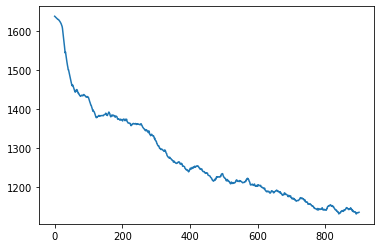

r mito Zooto.g

sFVt, urd the y fosU
bues yy Ioutt,
AiWl theri'lmeyOe so,v
M!
Al?tt
andUsas mod.
An
me
Thith:
hace shennemman moe ho., oot hy whauwdso harethaL fotvtle keath the thiiche nor;, as ooy!



In [40]:
layers = [RNNLayer(hidden_size=256, output_size=62)]
mod = RNNModel(layers=layers,
               vocab_size=62, sequence_length=10,
               loss=SoftmaxCrossEntropy())
optim = SGD(lr=0.001, gradient_clipping=True)
trainer = RNNTrainer('resources/input.txt', mod, optim)
trainer.train(1000, sample_every=100)

#### Limitations of “Vanilla” RNNNodes

Remember: the purpose of RNNs is to model dependencies in sequences of data. Thinking of modeling the price of oil as our canonical example, this means that we should be able to uncover the relationship between the sequence of features we’ve seen in the last several time steps and what will happen with the price of oil in the next time step. But how long should *several* be? For the price of oil, we might imagine that the relationship between what happened yesterday—one time step before—would be most important for predicting the price of oil tomorrow, with the day before being less important, and the importance generally decaying as we move backward in time.

While this is true for many real-world problems, there are domains to which we’d like to apply RNNs where we would want to learn extremely long-range dependencies. Language modeling is the canonical example here—that is, building a model that can predict the next character, word, or word part, given a theoretically extremely long series of past words or characters (since this is a particularly prevalent application, we’ll discuss some details specific to language modeling later in this chapter). For this, vanilla RNNs are usually insufficient. Now that we’ve seen their details, we can understand why: at each time step, the hidden state is multiplied by the same weight matrix across all time steps in the layer. **Consider what happens when we multiply a number by a value x over and over again: if x < 1, the number decreases exponentially to 0, and if x > 1, the number increases exponentially to infinity**. 

Recurrent neural networks have the same issues: over long time horizons, because the same set of weights is multiplied by the hidden state at each time step, the gradient for these weights tends to become either extremely small or extremely large. The former is known as the vanishing gradient problem and the latter is known as the exploding gradient problem. Both make it hard to train RNNs to model the very long term dependencies (50–100 time steps) needed for high-quality language modeling. The two commonly used modifications of the vanilla RNN architectures we’ll cover next both significantly mitigate this problem

## GRU

In [41]:
class GRUNode(object):

    def __init__(self):
        '''
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        '''
        pass
        
    def forward(self, 
                X_in: ndarray, 
                H_in: ndarray,
                params_dict: Dict[str, Dict[str, ndarray]]) -> Tuple[ndarray]:
        '''
        param X_in: numpy array of shape (batch_size, vocab_size)
        param H_in: numpy array of shape (batch_size, hidden_size)
        return self.X_out: numpy array of shape (batch_size, vocab_size)
        return self.H_out: numpy array of shape (batch_size, hidden_size)
        '''
        self.X_in = X_in
        self.H_in = H_in        
        
        # reset gate
        self.X_r = np.dot(X_in, params_dict['W_xr']['value'])
        self.H_r = np.dot(H_in, params_dict['W_hr']['value'])

        # update gate        
        self.X_u = np.dot(X_in, params_dict['W_xu']['value'])
        self.H_u = np.dot(H_in, params_dict['W_hu']['value'])        
        
        # gates   
        self.r_int = self.X_r + self.H_r + params_dict['B_r']['value']
        self.r = sigmoid(self.r_int)
        
        self.u_int = self.X_r + self.H_r + params_dict['B_u']['value']
        self.u = sigmoid(self.u_int)

        # new state        
        self.h_reset = self.r * H_in
        self.X_h = np.dot(X_in, params_dict['W_xh']['value'])
        self.H_h = np.dot(self.h_reset, params_dict['W_hh']['value']) 
        self.h_bar_int = self.X_h + self.H_h + params_dict['B_h']['value']
        self.h_bar = tanh(self.h_bar_int)        
        
        self.H_out = self.u * self.H_in + (1 - self.u) * self.h_bar

        self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']
        
        return self.X_out, self.H_out


    def backward(self, 
                 X_out_grad: ndarray, 
                 H_out_grad: ndarray, 
                 params_dict: Dict[str, Dict[str, ndarray]]):
        
        params_dict['B_v']['deriv'] += X_out_grad.sum(axis=0)
        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)

        dh_out = np.dot(X_out_grad, params_dict['W_v']['value'].T)        
        dh_out += H_out_grad
                         
        du = self.H_in * H_out_grad - self.h_bar * H_out_grad 
        dh_bar = (1 - self.u) * H_out_grad
        
        dh_bar_int = dh_bar * dtanh(self.h_bar_int)
        params_dict['B_h']['deriv'] += dh_bar_int.sum(axis=0)
        params_dict['W_xh']['deriv'] += np.dot(self.X_in.T, dh_bar_int)
        
        dX_in = np.dot(dh_bar_int, params_dict['W_xh']['value'].T)
 
        params_dict['W_hh']['deriv'] += np.dot(self.h_reset.T, dh_bar_int)
        dh_reset = np.dot(dh_bar_int, params_dict['W_hh']['value'].T)   
        
        dr = dh_reset * self.H_in
        dH_in = dh_reset * self.r        
        
        # update branch
        du_int = dsigmoid(self.u_int) * du
        params_dict['B_u']['deriv'] += du_int.sum(axis=0)

        dX_in += np.dot(du_int, params_dict['W_xu']['value'].T)
        params_dict['W_xu']['deriv'] += np.dot(self.X_in.T, du_int)
        
        dH_in += np.dot(du_int, params_dict['W_hu']['value'].T)
        params_dict['W_hu']['deriv'] += np.dot(self.H_in.T, du_int)        

        # reset branch
        dr_int = dsigmoid(self.r_int) * dr
        params_dict['B_r']['deriv'] += dr_int.sum(axis=0)

        dX_in += np.dot(dr_int, params_dict['W_xr']['value'].T)
        params_dict['W_xr']['deriv'] += np.dot(self.X_in.T, dr_int)
        
        dH_in += np.dot(dr_int, params_dict['W_hr']['value'].T)
        params_dict['W_hr']['deriv'] += np.dot(self.H_in.T, dr_int)   
        
        return dX_in, dH_in

In [42]:
class GRULayer(object):

    def __init__(self,
                 hidden_size: int,
                 output_size: int,
                 weight_scale: float = 0.01):
        '''
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param learning_rate: float - the learning rate
        '''
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, hidden_size))       
        self.first = True

        
    def _init_params(self,
                     input_: ndarray):
        
        self.vocab_size = input_.shape[2]

        self.params = {}
        self.params['W_xr'] = {}
        self.params['W_hr'] = {}
        self.params['B_r'] = {}
        self.params['W_xu'] = {}
        self.params['W_hu'] = {}
        self.params['B_u'] = {}
        self.params['W_xh'] = {}
        self.params['W_hh'] = {}
        self.params['B_h'] = {}        
        self.params['W_v'] = {}
        self.params['B_v'] = {}
        
        self.params['W_xr']['value'] = np.random.normal(loc=0.0,
                                                        scale=self.weight_scale,
                                                        size=(self.vocab_size, self.hidden_size))
        self.params['W_hr']['value'] = np.random.normal(loc=0.0,
                                                        scale=self.weight_scale,
                                                        size=(self.hidden_size, self.hidden_size))        
        self.params['B_r']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(1, self.hidden_size))
        self.params['W_xu']['value'] = np.random.normal(loc=0.0,
                                                        scale=self.weight_scale,
                                                        size=(self.vocab_size, self.hidden_size))
        self.params['W_hu']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.hidden_size, self.hidden_size))
        self.params['B_u']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_xh']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.vocab_size, self.hidden_size))
        self.params['W_hh']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.hidden_size, self.hidden_size))
        self.params['B_h']['value'] = np.random.normal(loc=0.0,
                                                       scale=1.0,
                                                       size=(1, self.hidden_size))
        self.params['W_v']['value'] = np.random.normal(loc=0.0,
                                                       scale=1.0,
                                                       size=(self.hidden_size, self.output_size))
        self.params['B_v']['value'] = np.random.normal(loc=0.0,
                                                       scale=1.0,
                                                       size=(1, self.output_size))    
        
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['value'])
        
        self.cells = [GRUNode() for x in range(input_.shape[1])]


    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])
                    
        
    def forward(self, x_seq_in: ndarray):
        '''
        param x_seq_in: numpy array of shape (batch_size, sequence_length, vocab_size)
        return x_seq_out: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''
        if self.first:
            self._init_params(x_seq_in)
            self.first=False
        
        batch_size = x_seq_in.shape[0]
        
        H_in = np.copy(self.start_H)

        H_in = np.repeat(H_in, batch_size, axis=0)      

        sequence_length = x_seq_in.shape[1]
        
        x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))
        
        for t in range(sequence_length):

            x_in = x_seq_in[:, t, :]
            
            y_out, H_in = self.cells[t].forward(x_in, H_in, self.params)
      
            x_seq_out[:, t, :] = y_out
    
        self.start_H = H_in.mean(axis=0, keepdims=True)     
        
        return x_seq_out


    def backward(self, x_seq_out_grad: ndarray):
        '''
        param loss_grad: numpy array of shape (batch_size, sequence_length, vocab_size)
        return loss_grad_out: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''
        
        batch_size = x_seq_out_grad.shape[0]
        
        h_in_grad = np.zeros((batch_size, self.hidden_size))        
        
        num_chars = x_seq_out_grad.shape[1]
        
        x_seq_in_grad = np.zeros((batch_size, num_chars, self.vocab_size))
        
        for t in reversed(range(num_chars)):
            
            x_out_grad = x_seq_out_grad[:, t, :]

            grad_out, h_in_grad = \
                self.cells[t].backward(x_out_grad, h_in_grad, self.params)
        
            x_seq_in_grad[:, t, :] = grad_out
        
        return x_seq_in_grad

### LSTM Layer

In [43]:
class LSTMNode:

    def __init__(self):
        '''
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        '''
        pass
        
    def forward(self, 
                X_in: ndarray, 
                H_in: ndarray, 
                C_in: ndarray, 
                params_dict: Dict[str, Dict[str, ndarray]]):
        '''
        param X_in: numpy array of shape (batch_size, vocab_size)
        param H_in: numpy array of shape (batch_size, hidden_size)
        param C_in: numpy array of shape (batch_size, hidden_size)
        return self.X_out: numpy array of shape (batch_size, output_size)
        return self.H: numpy array of shape (batch_size, hidden_size)
        return self.C: numpy array of shape (batch_size, hidden_size)
        '''
        self.X_in = X_in
        self.C_in = C_in

        self.Z = np.column_stack((X_in, H_in))
        
        self.f_int = np.dot(self.Z, params_dict['W_f']['value']) + params_dict['B_f']['value']
        self.f = sigmoid(self.f_int)
        
        self.i_int = np.dot(self.Z, params_dict['W_i']['value']) + params_dict['B_i']['value']
        self.i = sigmoid(self.i_int)
        self.C_bar_int = np.dot(self.Z, params_dict['W_c']['value']) + params_dict['B_c']['value']
        self.C_bar = tanh(self.C_bar_int)

        self.C_out = self.f * C_in + self.i * self.C_bar
        self.o_int = np.dot(self.Z, params_dict['W_o']['value']) + params_dict['B_o']['value']
        self.o = sigmoid(self.o_int)
        self.H_out = self.o * tanh(self.C_out)

        self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']
        
        return self.X_out, self.H_out, self.C_out 


    def backward(self, 
                 X_out_grad: ndarray, 
                 H_out_grad: ndarray, 
                 C_out_grad: ndarray, 
                 params_dict: Dict[str, Dict[str, ndarray]]):
        '''
        param loss_grad: numpy array of shape (1, vocab_size)
        param dh_next: numpy array of shape (1, hidden_size)
        param dC_next: numpy array of shape (1, hidden_size)
        param LSTM_Params: LSTM_Params object
        return self.dx_prev: numpy array of shape (1, vocab_size)
        return self.dH_prev: numpy array of shape (1, hidden_size)
        return self.dC_prev: numpy array of shape (1, hidden_size)
        '''
        
        assert_same_shape(X_out_grad, self.X_out)
        assert_same_shape(H_out_grad, self.H_out)
        assert_same_shape(C_out_grad, self.C_out)

        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)
        params_dict['B_v']['deriv'] += X_out_grad.sum(axis=0)

        dh_out = np.dot(X_out_grad, params_dict['W_v']['value'].T)        
        dh_out += H_out_grad
                         
        do = dh_out * tanh(self.C_out)
        do_int = dsigmoid(self.o_int) * do
        params_dict['W_o']['deriv'] += np.dot(self.Z.T, do_int)
        params_dict['B_o']['deriv'] += do_int.sum(axis=0)

        dC_out = dh_out * self.o * dtanh(self.C_out)
        dC_out += C_out_grad
        dC_bar = dC_out * self.i
        dC_bar_int = dtanh(self.C_bar_int) * dC_bar
        params_dict['W_c']['deriv'] += np.dot(self.Z.T, dC_bar_int)
        params_dict['B_c']['deriv'] += dC_bar_int.sum(axis=0)

        di = dC_out * self.C_bar
        di_int = dsigmoid(self.i_int) * di
        params_dict['W_i']['deriv'] += np.dot(self.Z.T, di_int)
        params_dict['B_i']['deriv'] += di_int.sum(axis=0)

        df = dC_out * self.C_in
        df_int = dsigmoid(self.f_int) * df
        params_dict['W_f']['deriv'] += np.dot(self.Z.T, df_int)
        params_dict['B_f']['deriv'] += df_int.sum(axis=0)

        dz = (np.dot(df_int, params_dict['W_f']['value'].T)
             + np.dot(di_int, params_dict['W_i']['value'].T)
             + np.dot(dC_bar_int, params_dict['W_c']['value'].T)
             + np.dot(do_int, params_dict['W_o']['value'].T))
    
        dx_prev = dz[:, :self.X_in.shape[1]]
        dH_prev = dz[:, self.X_in.shape[1]:]
        dC_prev = self.f * dC_out

        return dx_prev, dH_prev, dC_prev

In [44]:
class LSTMLayer:

    def __init__(self,
                 hidden_size: int,
                 output_size: int,
                 weight_scale: float = 0.01):
        '''
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param learning_rate: float - the learning rate
        '''
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, hidden_size))
        self.start_C = np.zeros((1, hidden_size))        
        self.first = True

        
    def _init_params(self,
                     input_: ndarray):
        
        self.vocab_size = input_.shape[2]

        self.params = {}
        self.params['W_f'] = {}
        self.params['B_f'] = {}
        self.params['W_i'] = {}
        self.params['B_i'] = {}
        self.params['W_c'] = {}
        self.params['B_c'] = {}
        self.params['W_o'] = {}
        self.params['B_o'] = {}        
        self.params['W_v'] = {}
        self.params['B_v'] = {}
        
        self.params['W_f']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size =(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_f']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(1, self.hidden_size))
        self.params['W_i']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_i']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_c']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_c']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_o']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_o']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))       
        self.params['W_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size, self.output_size))
        self.params['B_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.output_size))
        
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['value'])
        
        self.cells = [LSTMNode() for x in range(input_.shape[1])]


    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])
                    
        
    def forward(self, x_seq_in: ndarray):
        '''
        param x_seq_in: numpy array of shape (batch_size, sequence_length, vocab_size)
        return x_seq_out: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''
        if self.first:
            self._init_params(x_seq_in)
            self.first=False
        
        batch_size = x_seq_in.shape[0]
        
        H_in = np.copy(self.start_H)
        C_in = np.copy(self.start_C)
        
        H_in = np.repeat(H_in, batch_size, axis=0)
        C_in = np.repeat(C_in, batch_size, axis=0)        

        sequence_length = x_seq_in.shape[1]
        
        x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))
        
        for t in range(sequence_length):

            x_in = x_seq_in[:, t, :]
            
            y_out, H_in, C_in = self.cells[t].forward(x_in, H_in, C_in, self.params)
      
            x_seq_out[:, t, :] = y_out
    
        self.start_H = H_in.mean(axis=0, keepdims=True)
        self.start_C = C_in.mean(axis=0, keepdims=True)        
        
        return x_seq_out


    def backward(self, x_seq_out_grad: ndarray):
        '''
        param loss_grad: numpy array of shape (batch_size, sequence_length, vocab_size)
        return loss_grad_out: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''
        
        batch_size = x_seq_out_grad.shape[0]
        
        h_in_grad = np.zeros((batch_size, self.hidden_size))
        c_in_grad = np.zeros((batch_size, self.hidden_size))        
        
        num_chars = x_seq_out_grad.shape[1]
        
        x_seq_in_grad = np.zeros((batch_size, num_chars, self.vocab_size))
        
        for t in reversed(range(num_chars)):
            
            x_out_grad = x_seq_out_grad[:, t, :]

            grad_out, h_in_grad, c_in_grad = \
                self.cells[t].backward(x_out_grad, h_in_grad, c_in_grad, self.params)
        
            x_seq_in_grad[:, t, :] = grad_out
        
        return x_seq_in_grad

In [45]:
class LSTMModel(object):
    '''
    The Model class that takes in inputs and targets and actually trains the network and calculates the loss.
    '''
    def __init__(self, 
                 layers: List[LSTMLayer],
                 sequence_length: int, 
                 vocab_size: int, 
                 hidden_size: int,
                 loss: Loss):
        '''
        param num_layers: int - the number of layers in the network
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the each layer of the network.
        '''
        self.layers = layers
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.loss = loss
        for layer in self.layers:
            setattr(layer, 'sequence_length', sequence_length)

        
    def forward(self, 
                x_batch: ndarray):
        '''
        param inputs: list of integers - a list of indices of characters being passed in as the 
        input sequence of the network.
        returns x_batch_in: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''       
        
        for layer in self.layers:

            x_batch = layer.forward(x_batch)
                
        return x_batch
        
    def backward(self, 
                 loss_grad: ndarray):
        '''
        param loss_grad: numpy array with shape (batch_size, sequence_length, vocab_size)
        returns loss: float, representing mean squared error loss
        '''

        for layer in reversed(self.layers):

            loss_grad = layer.backward(loss_grad)
            
        return loss_grad
                
    def single_step(self, 
                    x_batch: ndarray, 
                    y_batch: ndarray):
        '''
        The step that does it all:
        1. Forward pass & softmax
        2. Compute loss and loss gradient
        3. Backward pass
        4. Update parameters
        param inputs: array of length sequence_length that represents the character indices of the inputs to
        the network
        param targets: array of length sequence_length that represents the character indices of the targets
        of the network 
        return loss
        '''  
        
        x_batch_out = self.forward(x_batch)
        
        loss = self.loss.forward(x_batch_out, y_batch)
        
        loss_grad = self.loss.backward()
        
        for layer in self.layers:
            layer._clear_gradients()
        
        self.backward(loss_grad)
        return loss

## Experiments

### One LSTM Layer

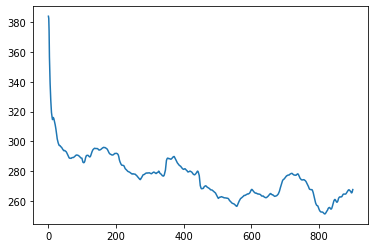

arhvkhoFrNFE:kYKATodamnnU;uFtyaAg:awSnnlc wemy,A mhty d.e .rlylSdc id cicT :fn:uRn'RbRNs;ul
EUBnnTWslveincOYSH
Fd
RKT
oMe tthalGucouwwpach
Brwy Me,sce
IoRKLxnSh u

RhRjRn urthtossbByeAAS k d:o urpaiDw


In [47]:
layers1 = [LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers1,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = AdaGrad(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('resources/input.txt', mod, optim, batch_size=3)
trainer.train(1000, sample_every=100)

### Multiple Layers

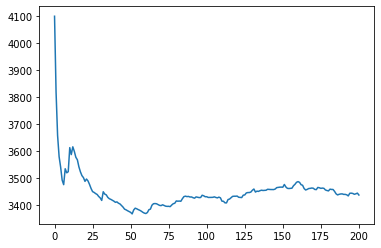

lZeeata umleh  
r t:tsehlerSue 
lhalhsUihaeuhPhni
aroA  icedy o. Tah,at a;eoe:ouB sabue,Ggnhulyoe:eedb 
ts,,
t .Isfahg cf u.audls gfln , e!i   
 e gaad a,mtfe.t  uuo odyhwbelt lsme Oknsmhk,aorUpnyMeut


In [ ]:
layers3 = [GRULayer(hidden_size=256, output_size=128, weight_scale=0.1),
           LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers3,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = AdaGrad(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('resources/input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)